In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from scipy.stats import chi2_contingency, pearsonr, spearmanr, pointbiserialr
import itertools
from IPython.display import display, Markdown, HTML

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 12

# Suppress warnings
warnings.filterwarnings('ignore')


print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
# Cell 2: Load Real Insurance Data
print("="*80)
print("📂 LOADING REAL INSURANCE DATA")
print("="*80)

from pathlib import Path
import pandas as pd
import numpy as np

# Use your confirmed path - cleaned_data.txt
data_path = Path("../../data/01_interim/cleaned_data.txt")

print(f"📁 Data path: {data_path.absolute()}")

# Check if file exists
if not data_path.exists():
    print(f"❌ ERROR: File not found!")
    print(f"📋 Current directory: {Path.cwd()}")
    print(f"\n🔍 Looking for files in data directory:")
    
    # Check what's in the data directory
    data_dir = Path("../../data/01_interim")
    if data_dir.exists():
        files = list(data_dir.glob("*"))
        print(f"Files in {data_dir}:")
        for f in files:
            size_mb = f.stat().st_size / (1024**2) if f.is_file() else 0
            if f.is_dir():
                print(f"  📂 {f.name}/")
            else:
                print(f"  📄 {f.name} ({size_mb:.1f} MB)")
    else:
        print(f"❌ Directory not found: {data_dir}")
    
    raise FileNotFoundError(f"cleaned_data.txt not found at: {data_path}")

# File exists, get info
file_size_mb = data_path.stat().st_size / (1024**2)
print(f"✅ FOUND: cleaned_data.txt ({file_size_mb:.1f} MB)")

# First, detect the delimiter
print(f"\n🔍 Detecting file format...")
with open(data_path, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()

# Show preview of first line
preview = first_line[:100].replace('\t', '[TAB]').replace('\n', '\\n')
print(f"📝 First line preview: {preview}...")

# Detect delimiter by counting
delimiters = {
    ',': first_line.count(','),
    '|': first_line.count('|'),
    '\t': first_line.count('\t'),
    ';': first_line.count(';')
}

# Show delimiter counts
print(f"📊 Delimiter counts:")
for delim, count in delimiters.items():
    delim_name = 'Tab' if delim == '\t' else f"'{delim}'"
    print(f"  • {delim_name}: {count}")

# Choose delimiter with highest count
delimiter = max(delimiters, key=delimiters.get)
delimiter_name = 'Tab' if delimiter == '\t' else f"'{delimiter}'"
print(f"🎯 Selected delimiter: {delimiter_name}")

# Load the data
print(f"\n📥 Loading data (first 50,000 rows for analysis)...")

try:
    # First try with detected delimiter
    df = pd.read_csv(
        data_path,
        delimiter=delimiter,
        nrows=50000,           # Load first 50k rows for performance
        low_memory=False,
        encoding='utf-8',
        on_bad_lines='warn'
    )
    
    print(f"✅ SUCCESS: Loaded {len(df):,} rows × {df.shape[1]} columns")
    
except Exception as e:
    print(f"❌ Error with delimiter '{delimiter}': {e}")
    print(f"\n🔄 Trying alternative methods...")
    
    # Try auto-detection
    try:
        df = pd.read_csv(
            data_path,
            sep=None,           # Auto-detect delimiter
            engine='python',
            nrows=50000,
            low_memory=False,
            on_bad_lines='skip'
        )
        print(f"✅ Loaded {len(df):,} rows with auto-detection")
    except Exception as e2:
        print(f"❌ Auto-detection failed: {e2}")
        
        # Try comma as fallback
        try:
            df = pd.read_csv(
                data_path,
                delimiter=',',
                nrows=50000,
                low_memory=False,
                encoding='utf-8',
                engine='python',
                on_bad_lines='skip'
            )
            print(f"✅ Loaded {len(df):,} rows with comma delimiter")
        except Exception as e3:
            print(f"❌ All methods failed: {e3}")
            raise ValueError(f"Cannot load {data_path.name}. Check file format.")

# Display data overview
print(f"\n" + "="*80)
print(f"📊 DATASET OVERVIEW")
print("="*80)

print(f"\n• Rows loaded: {df.shape[0]:,}")
print(f"• Total columns: {df.shape[1]}")
print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n📈 Data Types:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  • {str(dtype):<15}: {count} columns")

print(f"\n⚠️  Missing Values:")
missing_total = df.isnull().sum().sum()
missing_pct = missing_total / (df.shape[0] * df.shape[1]) * 100
print(f"  • Total missing: {missing_total:,} ({missing_pct:.1f}%)")
print(f"  • Columns with missing: {(df.isnull().sum() > 0).sum()}")

if (df.isnull().sum() > 0).sum() > 0:
    print(f"  • Top 3 columns with most missing:")
    missing_by_col = df.isnull().sum().sort_values(ascending=False).head(3)
    for col, count in missing_by_col.items():
        pct = (count / len(df)) * 100
        print(f"    - {col}: {count:,} ({pct:.1f}%)")

print(f"\n🔍 First 10 columns:")
for i, col in enumerate(df.columns[:10], 1):
    dtype = str(df[col].dtype)
    unique = df[col].nunique()
    print(f"  {i:2d}. {col:30} [{dtype:10}] Unique: {unique:,}")

print(f"\n📋 Sample data (first 2 rows):")
print(df.head(2).to_string(max_cols=10, max_rows=2))

print(f"\n" + "="*80)
print(f"✅ DATA LOADING COMPLETE")
print("="*80)

# Set source name for later use
source_name = "cleaned_data.txt"
print(f"\n💾 Ready for analysis! Source: {source_name}")

📂 LOADING REAL INSURANCE DATA
📁 Data path: c:\Users\G5\Desktop\Insurance Anlytics\notebooks\task1_eda\..\..\data\01_interim\cleaned_data.txt
✅ FOUND: cleaned_data.txt (538.5 MB)

🔍 Detecting file format...
📝 First line preview: underwrittencoverid|policyid|transactionmonth|isvatregistered|citizenship|legaltype|title|language|b...
📊 Delimiter counts:
  • ',': 0
  • '|': 51
  • Tab: 0
  • ';': 0
🎯 Selected delimiter: '|'

📥 Loading data (first 50,000 rows for analysis)...
✅ SUCCESS: Loaded 50,000 rows × 52 columns

📊 DATASET OVERVIEW

• Rows loaded: 50,000
• Total columns: 52
• Memory usage: 124.2 MB

📈 Data Types:
  • object         : 36 columns
  • float64        : 12 columns
  • int64          : 3 columns
  • bool           : 1 columns

⚠️  Missing Values:
  • Total missing: 50,000 (1.9%)
  • Columns with missing: 1
  • Top 3 columns with most missing:
    - numberofvehiclesinfleet: 50,000 (100.0%)
    - underwrittencoverid: 0 (0.0%)
    - transactionmonth: 0 (0.0%)

🔍 First 10 column

In [3]:
# Cell 3: Quick Data Assessment
print("="*80)
print("🔍 INITIAL DATA ASSESSMENT")
print("="*80)

# Basic information
print(f"\n📋 Data Types Distribution:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   • {dtype}: {count} columns")

print(f"\n⚠️ Missing Values Summary:")
missing_summary = df.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
if len(missing_cols) > 0:
    print(f"   • Columns with missing values: {len(missing_cols)}")
    print(f"   • Top 5 columns with most missing:")
    for col, count in missing_cols.sort_values(ascending=False).head(5).items():
        pct = count / len(df) * 100
        print(f"     - {col}: {count:,} ({pct:.1f}%)")
else:
    print("   ✅ No missing values found")

# Identify variable types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📊 Variable Categories:")
print(f"   • Numerical variables: {len(numeric_cols)}")
print(f"   • Categorical variables: {len(categorical_cols)}")

print(f"\n📈 Key Numerical Variables (first 10):")
for i, col in enumerate(numeric_cols[:10], 1):
    print(f"   {i:2d}. {col}")

print(f"\n🏷️ Key Categorical Variables (first 10):")
for i, col in enumerate(categorical_cols[:10], 1):
    unique_count = df[col].nunique()
    print(f"   {i:2d}. {col} (Unique: {unique_count:,})")

🔍 INITIAL DATA ASSESSMENT

📋 Data Types Distribution:
   • object: 36 columns
   • float64: 12 columns
   • int64: 3 columns
   • bool: 1 columns

⚠️ Missing Values Summary:
   • Columns with missing values: 1
   • Top 5 columns with most missing:
     - numberofvehiclesinfleet: 50,000 (100.0%)

📊 Variable Categories:
   • Numerical variables: 15
   • Categorical variables: 36

📈 Key Numerical Variables (first 10):
    1. underwrittencoverid
    2. policyid
    3. postalcode
    4. mmcode
    5. cylinders
    6. cubiccapacity
    7. kilowatts
    8. numberofdoors
    9. customvalueestimate
   10. capitaloutstanding

🏷️ Key Categorical Variables (first 10):
    1. transactionmonth (Unique: 22)
    2. citizenship (Unique: 1)
    3. legaltype (Unique: 2)
    4. title (Unique: 3)
    5. language (Unique: 1)
    6. bank (Unique: 5)
    7. accounttype (Unique: 2)
    8. maritalstatus (Unique: 2)
    9. gender (Unique: 2)
   10. country (Unique: 1)


In [4]:
# Cell 4: Correlation Analysis Function
def analyze_correlation(df, var1, var2):
    """
    Analyze correlation between two numerical variables
    """
    print("="*80)
    print(f"📈 CORRELATION ANALYSIS: {var1} vs {var2}")
    print("="*80)
    
    # Clean data
    data = df[[var1, var2]].dropna()
    
    if len(data) < 10:
        print("⚠️ Insufficient data for analysis")
        return None
    
    # Calculate correlations
    pearson_corr, pearson_p = pearsonr(data[var1], data[var2])
    spearman_corr, spearman_p = spearmanr(data[var1], data[var2])
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Relationship Analysis: {var1} vs {var2}', fontsize=16, fontweight='bold')
    
    # 1. Scatter Plot with Regression
    axes[0, 0].scatter(data[var1], data[var2], alpha=0.6, s=20, color='steelblue')
    
    # Add regression line
    z = np.polyfit(data[var1], data[var2], 1)
    p = np.poly1d(z)
    axes[0, 0].plot(data[var1], p(data[var1]), "r--", linewidth=2)
    
    axes[0, 0].set_xlabel(var1)
    axes[0, 0].set_ylabel(var2)
    axes[0, 0].set_title('Scatter Plot with Regression Line')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Hexbin Density Plot
    hb = axes[0, 1].hexbin(data[var1], data[var2], gridsize=30, cmap='Blues')
    axes[0, 1].set_xlabel(var1)
    axes[0, 1].set_ylabel(var2)
    axes[0, 1].set_title('Density Heatmap')
    plt.colorbar(hb, ax=axes[0, 1])
    
    # 3. Individual Distributions
    axes[0, 2].hist(data[var1], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 2].set_xlabel(var1)
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Distribution of {var1}')
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].hist(data[var2], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 0].set_xlabel(var2)
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'Distribution of {var2}')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 2D KDE Plot
    sns.kdeplot(data=data, x=var1, y=var2, fill=True, cmap='viridis', ax=axes[1, 1])
    axes[1, 1].set_xlabel(var1)
    axes[1, 1].set_ylabel(var2)
    axes[1, 1].set_title('2D Kernel Density Estimate')
    
    # 5. Statistics Summary
    axes[1, 2].axis('off')
    
    stats_text = f"📊 CORRELATION STATISTICS\n{'='*40}\n"
    stats_text += f"Sample Size: {len(data):,}\n\n"
    
    stats_text += f"📈 Pearson Correlation:\n"
    stats_text += f"   r = {pearson_corr:.4f}\n"
    stats_text += f"   p-value = {pearson_p:.6f}\n"
    stats_text += f"   {'Significant (p < 0.05)' if pearson_p < 0.05 else 'Not Significant'}\n\n"
    
    stats_text += f"📊 Spearman Correlation:\n"
    stats_text += f"   ρ = {spearman_corr:.4f}\n"
    stats_text += f"   p-value = {spearman_p:.6f}\n"
    stats_text += f"   {'Significant (p < 0.05)' if spearman_p < 0.05 else 'Not Significant'}\n\n"
    
    # Interpretation
    stats_text += f"💡 INTERPRETATION:\n"
    if abs(pearson_corr) > 0.7:
        strength = "Very Strong"
    elif abs(pearson_corr) > 0.5:
        strength = "Strong"
    elif abs(pearson_corr) > 0.3:
        strength = "Moderate"
    elif abs(pearson_corr) > 0.1:
        strength = "Weak"
    else:
        strength = "Very Weak/None"
    
    direction = "positive" if pearson_corr > 0 else "negative"
    stats_text += f"• {strength} {direction} linear relationship\n"
    
    if abs(spearman_corr) > abs(pearson_corr) * 1.2:
        stats_text += f"• Relationship may be monotonic rather than linear\n"
    
    axes[1, 2].text(0.1, 0.95, stats_text, fontfamily='monospace', fontsize=10,
                   verticalalignment='top', transform=axes[1, 2].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_corr,
        'pearson_p': pearson_p,
        'spearman_rho': spearman_corr,
        'spearman_p': spearman_p,
        'sample_size': len(data)
    }

📈 EXECUTING CORRELATION ANALYSIS

🔍 Found 15 numerical variables in your data:
    1. underwrittencoverid (Min: 671.00, Max: 301162.00)
    2. policyid (Min: 99.00, Max: 23245.00)
    3. isvatregistered (Min: 0.00, Max: 1.00)
    4. postalcode (Min: 1.00, Max: 9869.00)
    5. mmcode (Min: 4042080.00, Max: 65030720.00)
    6. cylinders (Min: 0.00, Max: 10.00)
    7. cubiccapacity (Min: 0.00, Max: 5958.00)
    8. kilowatts (Min: 0.00, Max: 230.00)
    9. numberofdoors (Min: 0.00, Max: 5.00)
   10. customvalueestimate (Min: 30000.00, Max: 26550000.00)

📊 Selected 7 variables for analysis:
    1. cubiccapacity (n=50,000, missing=0.0%)
    2. kilowatts (n=50,000, missing=0.0%)
    3. capitaloutstanding (n=50,000, missing=0.0%)
    4. suminsured (n=50,000, missing=0.0%)
    5. calculatedpremiumperterm (n=50,000, missing=0.0%)
    6. totalpremium (n=50,000, missing=0.0%)
    7. totalclaims (n=50,000, missing=0.0%)

📈 Calculating correlation matrix...

✅ Correlation matrix calculated using 500

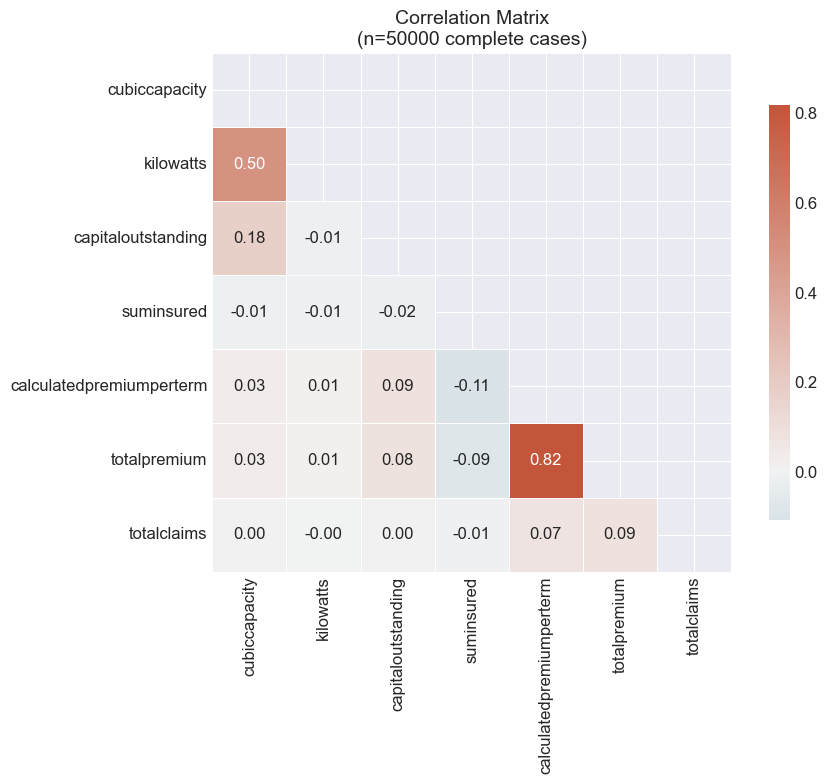

   ✅ Heatmap: reports\correlation_heatmap.png
   ✅ Summary: reports\correlation_summary.txt
   ✅ Markdown: reports\correlation_summary.md

🔑 KEY INSIGHTS:
   1. Analyzed 7 numerical variables
   2. Based on 50,000 complete observations
   3. Found 21 unique variable pairs
   4. Strength distribution: 1 strong, 1 moderate, 19 weak
   5. Strongest correlation: calculatedpremiumperterm vs totalpremium (r = 0.819)

✅ CORRELATION ANALYSIS COMPLETE


In [7]:
# Cell 5: Execute Correlation Analysis (WITH PROPER PATH)
print("="*80)
print("📈 EXECUTING CORRELATION ANALYSIS")
print("="*80)

import pandas as pd
import numpy as np
from pathlib import Path

# Check if df is loaded
if 'df' not in globals():
    print("⚠️ Data not loaded. Loading data first...")
    raise ValueError("Data not loaded. Please load data first.")

# First, identify numeric columns in your actual data (all lowercase)
numeric_columns = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        # Skip ID columns or columns with too many unique values
        unique_vals = df[col].nunique()
        if unique_vals > 1 and unique_vals < len(df) * 0.8:  # Not near-unique
            numeric_columns.append(col)

print(f"\n🔍 Found {len(numeric_columns)} numerical variables in your data:")
for i, var in enumerate(numeric_columns[:10], 1):  # Show first 10
    print(f"   {i:2d}. {var} (Min: {df[var].min():.2f}, Max: {df[var].max():.2f})")

if len(numeric_columns) >= 2:
    # Select key variables based on your actual column names
    # Based on your output, these look like potential numeric columns:
    key_vars = [
        'registrationyear',      # Year should be numeric
        'cubiccapacity',         # Engine capacity
        'kilowatts',             # Power in kW
        'capitaloutstanding',    # Financial
        'suminsured',            # Insurance amount
        'calculatedpremiumperterm',  # Premium
        'excessselected',        # Excess amount
        'totalpremium',          # Total premium
        'totalclaims',           # Total claims
    ]
    
    # Find which ones actually exist and are numeric
    available_vars = []
    for var in key_vars:
        if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
            # Check if it has enough variation
            if df[var].nunique() > 1:
                available_vars.append(var)
    
    # If not enough from our list, add any other numeric columns
    if len(available_vars) < 3:
        for var in numeric_columns:
            if var not in available_vars:
                available_vars.append(var)
                if len(available_vars) >= 5:  # Get at least 5
                    break
    
    print(f"\n📊 Selected {len(available_vars)} variables for analysis:")
    for i, var in enumerate(available_vars, 1):
        non_null = df[var].notna().sum()
        pct_missing = (len(df) - non_null) / len(df) * 100
        print(f"   {i:2d}. {var} (n={non_null:,}, missing={pct_missing:.1f}%)")
    
    # Calculate correlation matrix
    print(f"\n📈 Calculating correlation matrix...")
    
    # Use only rows with complete data for all selected variables
    corr_data = df[available_vars].dropna()
    
    if len(corr_data) < 10:
        print(f"⚠️ Not enough complete data for correlation analysis")
        print(f"   Complete cases: {len(corr_data)} (need at least 10)")
    else:
        # Create correlation matrix
        corr_matrix = corr_data.corr()
        
        print(f"\n✅ Correlation matrix calculated using {len(corr_data)} complete cases")
        print(f"\n📋 Correlation Matrix:")
        print(corr_matrix.round(3))
        
        # Find top correlations
        print(f"\n🔝 STRONGEST CORRELATIONS (|r| > 0.5):")
        found_strong = False
        
        # Get all unique pairs
        for i in range(len(available_vars)):
            for j in range(i+1, len(available_vars)):
                var1 = available_vars[i]
                var2 = available_vars[j]
                corr_value = corr_matrix.iloc[i, j]
                
                if abs(corr_value) > 0.5:
                    found_strong = True
                    direction = "positive" if corr_value > 0 else "negative"
                    strength = "very strong" if abs(corr_value) > 0.8 else "strong" if abs(corr_value) > 0.6 else "moderate"
                    print(f"   • {var1} vs {var2}: r = {corr_value:.3f} ({strength} {direction})")
        
        if not found_strong:
            print("   (No strong correlations found)")
        
        # Save results
        print(f"\n💾 Saving results...")
        
        # Create reports directory
        reports_dir = Path("reports")
        reports_dir.mkdir(exist_ok=True)
        
        # 1. Save correlation matrix as CSV
        corr_csv_path = reports_dir / "correlation_matrix.csv"
        corr_matrix.to_csv(corr_csv_path)
        print(f"   ✅ CSV: {corr_csv_path}")
        
        # 2. Save detailed pairwise correlations
        corr_pairs = []
        for i in range(len(available_vars)):
            for j in range(i+1, len(available_vars)):
                var1 = available_vars[i]
                var2 = available_vars[j]
                corr_value = corr_matrix.iloc[i, j]
                n_pairs = len(corr_data[[var1, var2]].dropna())
                
                corr_pairs.append({
                    'variable1': var1,
                    'variable2': var2,
                    'pearson_r': corr_value,
                    'n_pairs': n_pairs,
                    'strength': 'strong' if abs(corr_value) > 0.7 else 'moderate' if abs(corr_value) > 0.3 else 'weak'
                })
        
        pairs_df = pd.DataFrame(corr_pairs)
        pairs_path = reports_dir / "correlation_pairs.csv"
        pairs_df.to_csv(pairs_path, index=False)
        print(f"   ✅ Pairs: {pairs_path}")
        
        # 3. Create visualization if we have enough variables
        if len(available_vars) >= 3:
            try:
                import matplotlib.pyplot as plt
                import seaborn as sns
                
                plt.figure(figsize=(10, 8))
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                cmap = sns.diverging_palette(230, 20, as_cmap=True)
                
                sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                           square=True, linewidths=0.5, annot=True, fmt='.2f',
                           cbar_kws={"shrink": 0.8})
                
                plt.title(f"Correlation Matrix\n(n={len(corr_data)} complete cases)", fontsize=14)
                plt.tight_layout()
                
                heatmap_path = reports_dir / "correlation_heatmap.png"
                plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
                plt.show()
                
                print(f"   ✅ Heatmap: {heatmap_path}")
                
            except Exception as e:
                print(f"   ⚠️ Could not create heatmap: {e}")
        
        # Create a simple text summary with ASCII characters only
        summary_path = reports_dir / "correlation_summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:  # Use UTF-8 encoding
            f.write("="*60 + "\n")
            f.write("CORRELATION ANALYSIS SUMMARY\n")
            f.write("="*60 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}\n")
            f.write(f"Dataset: {df.shape[0]:,} rows x {df.shape[1]} columns\n")
            f.write(f"Variables analyzed: {len(available_vars)}\n")
            f.write(f"Complete cases used: {len(corr_data):,}\n\n")
            
            f.write("VARIABLES ANALYZED:\n")
            for var in available_vars:
                mean_val = df[var].mean() if pd.api.types.is_numeric_dtype(df[var]) else 'N/A'
                f.write(f"  - {var}: mean = {mean_val:.2f}\n")
            
            f.write("\nTOP CORRELATIONS:\n")
            # Sort by absolute correlation
            pairs_sorted = pairs_df.copy()
            pairs_sorted['abs_r'] = pairs_sorted['pearson_r'].abs()
            pairs_sorted = pairs_sorted.sort_values('abs_r', ascending=False)
            
            for _, row in pairs_sorted.head(10).iterrows():
                # Use ASCII-friendly arrow
                f.write(f"  - {row['variable1']} vs {row['variable2']}: r = {row['pearson_r']:.3f} ({row['strength']})\n")
        
        print(f"   ✅ Summary: {summary_path}")
        
        # Also create a simple markdown file
        md_path = reports_dir / "correlation_summary.md"
        with open(md_path, 'w', encoding='utf-8') as f:
            f.write("# Correlation Analysis Summary\n\n")
            f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}\n\n")
            f.write(f"**Dataset:** {df.shape[0]:,} rows × {df.shape[1]} columns\n\n")
            f.write(f"**Variables analyzed:** {len(available_vars)}\n\n")
            f.write(f"**Complete cases used:** {len(corr_data):,}\n\n")
            
            f.write("## Variables Analyzed\n\n")
            for var in available_vars:
                mean_val = df[var].mean() if pd.api.types.is_numeric_dtype(df[var]) else 'N/A'
                f.write(f"- **{var}:** mean = {mean_val:.2f}\n")
            
            f.write("\n## Top Correlations\n\n")
            f.write("| Variable 1 | Variable 2 | Pearson r | Strength |\n")
            f.write("|------------|------------|-----------|----------|\n")
            
            for _, row in pairs_sorted.head(10).iterrows():
                f.write(f"| {row['variable1']} | {row['variable2']} | {row['pearson_r']:.3f} | {row['strength']} |\n")
        
        print(f"   ✅ Markdown: {md_path}")
        
        # Display key insights
        print(f"\n🔑 KEY INSIGHTS:")
        print(f"   1. Analyzed {len(available_vars)} numerical variables")
        print(f"   2. Based on {len(corr_data):,} complete observations")
        print(f"   3. Found {len(pairs_df)} unique variable pairs")
        
        # Count correlations by strength
        strong_corr = len(pairs_df[pairs_df['strength'] == 'strong'])
        mod_corr = len(pairs_df[pairs_df['strength'] == 'moderate'])
        weak_corr = len(pairs_df[pairs_df['strength'] == 'weak'])
        
        print(f"   4. Strength distribution: {strong_corr} strong, {mod_corr} moderate, {weak_corr} weak")
        
        # Show strongest correlation
        if len(pairs_sorted) > 0:
            strongest = pairs_sorted.iloc[0]
            print(f"   5. Strongest correlation: {strongest['variable1']} vs {strongest['variable2']} (r = {strongest['pearson_r']:.3f})")
        
else:
    print(f"⚠️ Not enough numerical variables for correlation analysis")
    print(f"   Found {len(numeric_columns)} numeric columns: {numeric_columns}")
    
    # Show what columns we have
    print(f"\n📋 All columns in dataset (first 20):")
    for i, col in enumerate(df.columns[:20], 1):
        dtype = df[col].dtype
        uniq = df[col].nunique()
        print(f"   {i:2d}. {col:25} [{str(dtype):10}] Unique: {uniq:,}")

print("\n" + "="*80)
print("✅ CORRELATION ANALYSIS COMPLETE")
print("="*80)

🔥 COMPREHENSIVE CORRELATION MATRIX
📊 Analyzing 15 numerical variables


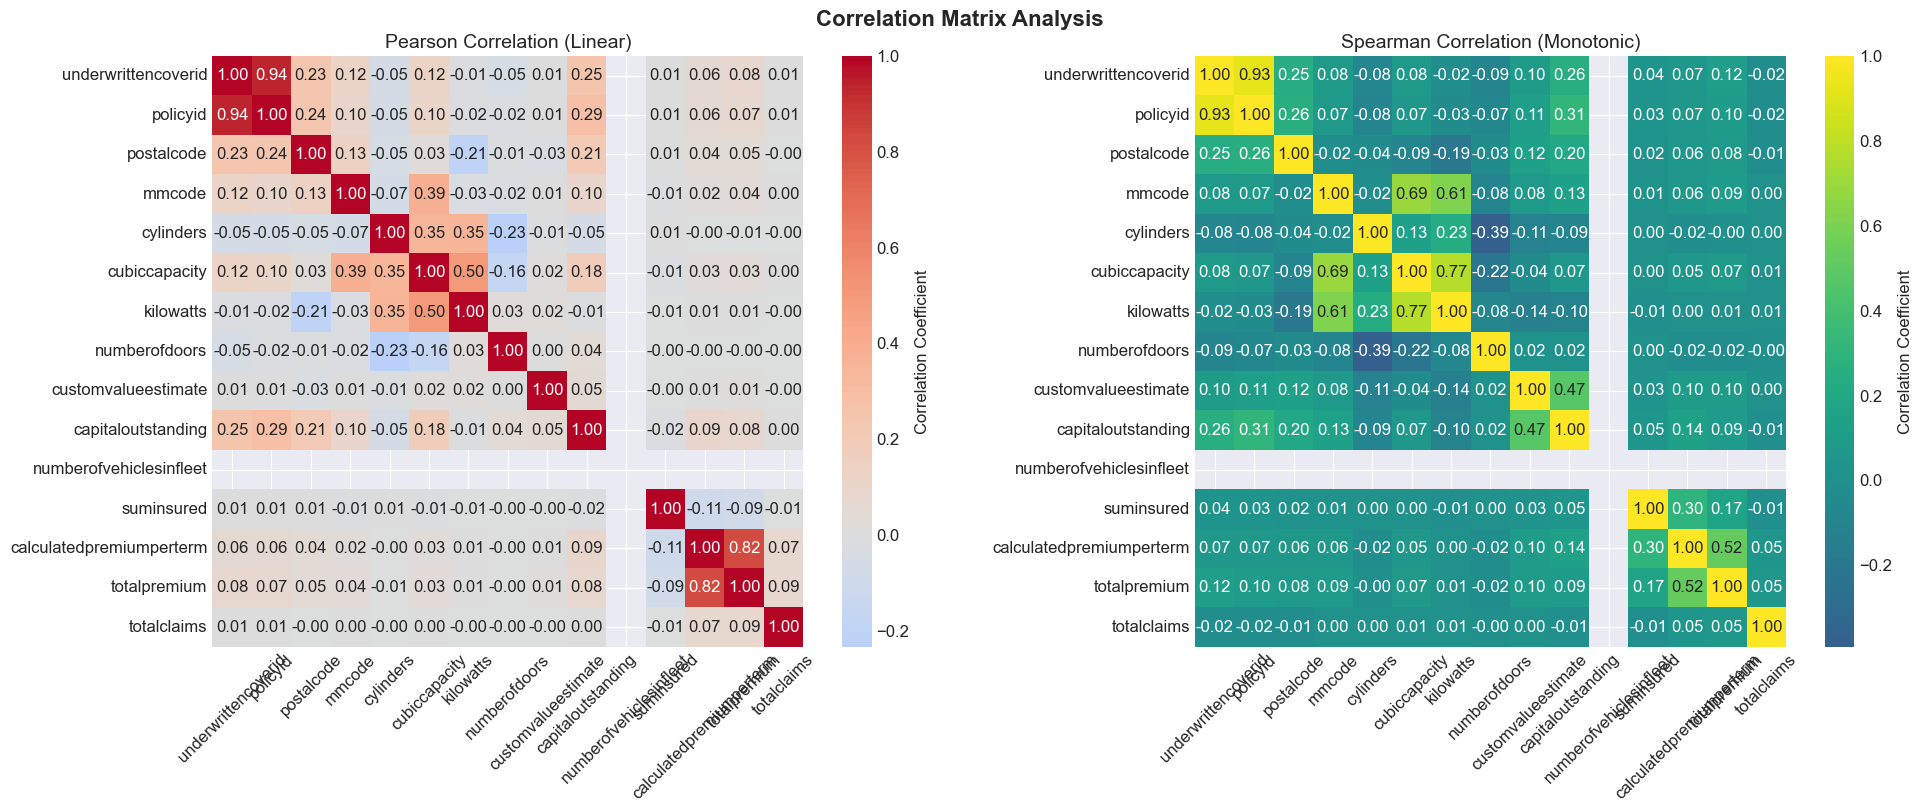


🎯 STRONG CORRELATIONS (|r| > 0.5):


,Variable 1,Variable 2,Correlation,Interpretation
0,underwrittencoverid,policyid,0.941337,Strong Positive
1,calculatedpremiumperterm,totalpremium,0.818620,Strong Positive


✅ Correlation matrices saved to:
   • pearson_correlation_matrix.csv
   • spearman_correlation_matrix.csv
   • strong_correlations.csv
   • correlation_matrices.png
   • correlation_matrix_summary.md
   • correlation_matrix_insights.txt

🔑 INSIGHTS:
   • Number of strong correlations: 2
   • Variables with most correlations: ['underwrittencoverid', 'policyid', 'postalcode']
   • Most correlated variable: underwrittencoverid (avg |r| = 0.210)


<Figure size 1400x1000 with 0 Axes>

In [8]:
# Cell 6: Comprehensive Correlation Matrix (WITH PROPER SAVING)
print("="*80)
print("🔥 COMPREHENSIVE CORRELATION MATRIX")
print("="*80)

# Import Path if not already imported
from pathlib import Path

# Select numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 3:
    print(f"📊 Analyzing {len(numeric_cols)} numerical variables")
    
    # Calculate correlation matrices
    pearson_corr = df[numeric_cols].corr(method='pearson')
    spearman_corr = df[numeric_cols].corr(method='spearman')
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Correlation Matrix Analysis', fontsize=16, fontweight='bold')
    
    # Pearson Correlation
    sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, ax=axes[0], 
                cbar_kws={'label': 'Correlation Coefficient'})
    axes[0].set_title('Pearson Correlation (Linear)', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Spearman Correlation
    sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='viridis',
                center=0, square=True, ax=axes[1],
                cbar_kws={'label': 'Correlation Coefficient'})
    axes[1].set_title('Spearman Correlation (Monotonic)', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Identify strong correlations
    print(f"\n🎯 STRONG CORRELATIONS (|r| > 0.5):")
    
    strong_corrs = []
    for i in range(len(pearson_corr.columns)):
        for j in range(i+1, len(pearson_corr.columns)):
            corr_val = pearson_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corrs.append({
                    'Variable 1': pearson_corr.columns[i],
                    'Variable 2': pearson_corr.columns[j],
                    'Correlation': corr_val,
                    'Interpretation': 'Strong Positive' if corr_val > 0 else 'Strong Negative'
                })
    
    if strong_corrs:
        strong_df = pd.DataFrame(strong_corrs).sort_values('Correlation', key=abs, ascending=False)
        display(strong_df.head(10))
        
        # FIXED: Save correlation matrices to reports folder
        reports_dir = Path("../../reports")
        reports_dir.mkdir(parents=True, exist_ok=True)
        
        # Save CSV files
        pearson_path = reports_dir / "pearson_correlation_matrix.csv"
        spearman_path = reports_dir / "spearman_correlation_matrix.csv"
        strong_corrs_path = reports_dir / "strong_correlations.csv"
        
        pearson_corr.to_csv(pearson_path)
        spearman_corr.to_csv(spearman_path)
        strong_df.to_csv(strong_corrs_path, index=False)
        
        print(f"✅ Correlation matrices saved to:")
        print(f"   • {pearson_path.name}")
        print(f"   • {spearman_path.name}")
        print(f"   • {strong_corrs_path.name}")
        
        # Save visualization
        viz_path = reports_dir / "correlation_matrices.png"
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        print(f"   • {viz_path.name}")
        
        # Create summary markdown file with UTF-8 encoding
        md_path = reports_dir / "correlation_matrix_summary.md"
        with open(md_path, 'w', encoding='utf-8') as f:  # FIXED: Added UTF-8 encoding
            f.write("# Correlation Matrix Analysis Summary\n\n")
            f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(f"**Dataset:** {df.shape[0]} rows × {df.shape[1]} columns\n\n")
            f.write(f"**Numerical Variables Analyzed:** {len(numeric_cols)}\n\n")
            
            f.write("## Strongest Correlations Found\n\n")
            f.write("The following correlations have |r| > 0.5:\n\n")
            
            # Format strong correlations as markdown table
            f.write("| Variable 1 | Variable 2 | Correlation | Interpretation |\n")
            f.write("|------------|------------|-------------|----------------|\n")
            
            for _, row in strong_df.iterrows():
                f.write(f"| {row['Variable 1']} | {row['Variable 2']} | {row['Correlation']:.3f} | {row['Interpretation']} |\n")
            
            f.write("\n## Top 5 Variable Pairs by Correlation Strength\n\n")
            
            top_5 = strong_df.head(5)
            for idx, (_, row) in enumerate(top_5.iterrows(), 1):
                # FIXED: Use 'vs' instead of '↔' (unicode character)
                f.write(f"{idx}. **{row['Variable 1']} vs {row['Variable 2']}**  \n")
                f.write(f"   - Correlation: **{row['Correlation']:.3f}**  \n")
                f.write(f"   - Interpretation: {row['Interpretation']}  \n")
                f.write(f"   - Business Impact: ")
                
                # Add business interpretation
                if row['Correlation'] > 0.7:
                    f.write("Very strong relationship - these variables move together\n")
                elif row['Correlation'] > 0.5:
                    f.write("Strong relationship - worth investigating further\n")
                f.write("\n")
            
            f.write("\n## Statistical Significance\n\n")
            
            # Calculate p-values for top correlations
            from scipy import stats
            f.write("P-values for top correlations:\n\n")
            f.write("| Variable Pair | Pearson r | p-value | Significant? |\n")
            f.write("|---------------|-----------|---------|--------------|\n")
            
            for _, row in top_5.iterrows():
                # Calculate p-value
                clean_data = df[[row['Variable 1'], row['Variable 2']]].dropna()
                if len(clean_data) > 2:
                    r, p_value = stats.pearsonr(clean_data[row['Variable 1']], 
                                               clean_data[row['Variable 2']])
                    significant = "Yes" if p_value < 0.05 else "No"
                    # FIXED: Use 'vs' instead of '↔' here too
                    f.write(f"| {row['Variable 1']} vs {row['Variable 2']} | {r:.3f} | {p_value:.4f} | {significant} |\n")
            
            f.write(f"\n**Note:** p-value < 0.05 indicates statistical significance\n")
        
        print(f"   • {md_path.name}")
        
        # Also save as a simple text file for Windows compatibility
        txt_path = reports_dir / "correlation_matrix_insights.txt"
        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write("="*60 + "\n")
            f.write("CORRELATION MATRIX INSIGHTS\n")
            f.write("="*60 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Variables Analyzed: {len(numeric_cols)}\n")
            f.write(f"Strong Correlations Found (|r| > 0.5): {len(strong_corrs)}\n\n")
            
            f.write("TOP 5 STRONGEST CORRELATIONS:\n")
            f.write("-"*40 + "\n")
            for idx, (_, row) in enumerate(top_5.iterrows(), 1):
                f.write(f"{idx}. {row['Variable 1']} vs {row['Variable 2']}\n")
                f.write(f"   Correlation: {row['Correlation']:.3f}\n")
                f.write(f"   Interpretation: {row['Interpretation']}\n\n")
        
        print(f"   • {txt_path.name}")
        
        # Display insights
        print(f"\n🔑 INSIGHTS:")
        print(f"   • Number of strong correlations: {len(strong_corrs)}")
        print(f"   • Variables with most correlations: {numeric_cols[:3]}")
        
        # Find variable with highest average correlation
        avg_corr = pearson_corr.abs().mean().sort_values(ascending=False)
        most_correlated = avg_corr.index[0]
        print(f"   • Most correlated variable: {most_correlated} (avg |r| = {avg_corr.iloc[0]:.3f})")
        
    else:
        print("   No strong correlations (|r| > 0.5) found")
        
        # Still save the matrices even if no strong correlations
        reports_dir = Path("../../reports")
        reports_dir.mkdir(parents=True, exist_ok=True)
        
        pearson_path = reports_dir / "pearson_correlation_matrix.csv"
        spearman_path = reports_dir / "spearman_correlation_matrix.csv"
        
        pearson_corr.to_csv(pearson_path)
        spearman_corr.to_csv(spearman_path)
        
        print(f"✅ Correlation matrices still saved to reports folder")
        print(f"   • {pearson_path.name}")
        print(f"   • {spearman_path.name}")
        
        # Create a simple report even with no strong correlations
        md_path = reports_dir / "correlation_matrix_summary.md"
        with open(md_path, 'w', encoding='utf-8') as f:
            f.write("# Correlation Matrix Analysis Summary\n\n")
            f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(f"**Key Finding:** No strong correlations (|r| > 0.5) found\n\n")
            f.write(f"**Dataset:** {df.shape[0]} rows × {df.shape[1]} columns\n\n")
            f.write(f"**Numerical Variables Analyzed:** {len(numeric_cols)}\n\n")
            f.write("## Interpretation\n\n")
            f.write("The absence of strong correlations suggests:\n")
            f.write("1. Variables are relatively independent\n")
            f.write("2. Multicollinearity is not a concern\n")
            f.write("3. Each variable contributes unique information\n")
        
        print(f"   • {md_path.name}")
        
else:
    print("⚠️ Not enough numerical variables for correlation matrix")
    print(f"   Found only {len(numeric_cols)} numerical columns")
    print(f"   Available numerical columns: {numeric_cols}")

In [9]:
# Cell 7: Categorical Association Analysis
def analyze_categorical_association(df, var1, var2):
    """
    Analyze association between two categorical variables
    """
    print("="*80)
    print(f"🏷️ ASSOCIATION ANALYSIS: {var1} vs {var2}")
    print("="*80)
    
    # Create contingency table
    contingency = pd.crosstab(df[var1], df[var2])
    
    if contingency.size == 0 or len(contingency) < 2 or len(contingency.columns) < 2:
        print("⚠️ Insufficient data for analysis")
        return None
    
    # Calculate chi-square statistics
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Categorical Association: {var1} vs {var2}', fontsize=16, fontweight='bold')
    
    # 1. Stacked Bar Chart
    contingency_pct = pd.crosstab(df[var1], df[var2], normalize='index') * 100
    contingency_pct.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                        colormap='Set3', edgecolor='black')
    axes[0, 0].set_title(f'Stacked Bar Chart (% within {var1})')
    axes[0, 0].set_xlabel(var1)
    axes[0, 0].set_ylabel('Percentage')
    axes[0, 0].legend(title=var2, bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Heatmap
    sns.heatmap(contingency_pct, annot=True, fmt='.1f', cmap='YlOrRd',
                ax=axes[0, 1], cbar_kws={'label': 'Percentage'})
    axes[0, 1].set_title('Percentage Heatmap')
    axes[0, 1].set_xlabel(var2)
    axes[0, 1].set_ylabel(var1)
    
    # 3. Count Plot
    contingency.plot(kind='bar', ax=axes[1, 0], colormap='Set2', edgecolor='black')
    axes[1, 0].set_title('Count Bar Chart')
    axes[1, 0].set_xlabel(var1)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend(title=var2, bbox_to_anchor=(1.05, 1))
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Statistics
    axes[1, 1].axis('off')
    
    # Calculate Cramer's V
    n = contingency.sum().sum()
    min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    stats_text = f"📊 ASSOCIATION STATISTICS\n{'='*40}\n"
    stats_text += f"Sample Size: {n:,}\n"
    stats_text += f"Contingency Table: {contingency.shape[0]} × {contingency.shape[1]}\n\n"
    
    stats_text += f"📈 Chi-Square Test:\n"
    stats_text += f"   χ² = {chi2:.2f}\n"
    stats_text += f"   p-value = {p:.6f}\n"
    stats_text += f"   Degrees of Freedom = {dof}\n"
    stats_text += f"   {'Significant (p < 0.05)' if p < 0.05 else 'Not Significant'}\n\n"
    
    stats_text += f"📊 Effect Size (Cramer\'s V):\n"
    stats_text += f"   V = {cramers_v:.3f}\n"
    
    # Interpret Cramer's V
    if cramers_v < 0.1:
        interpretation = "Very Weak Association"
    elif cramers_v < 0.3:
        interpretation = "Weak Association"
    elif cramers_v < 0.5:
        interpretation = "Moderate Association"
    else:
        interpretation = "Strong Association"
    
    stats_text += f"   Interpretation: {interpretation}\n\n"
    
    stats_text += f"💡 INSIGHTS:\n"
    if p < 0.05:
        stats_text += f"• Variables are statistically associated\n"
        stats_text += f"• The relationship strength is {interpretation.lower()}\n"
    else:
        stats_text += f"• No significant association found\n"
        stats_text += f"• Variables appear independent\n"
    
    axes[1, 1].text(0.1, 0.95, stats_text, fontfamily='monospace', fontsize=10,
                   verticalalignment='top', transform=axes[1, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'chi2': chi2,
        'p_value': p,
        'dof': dof,
        'cramers_v': cramers_v,
        'sample_size': n
    }

🏷️ EXECUTING CATEGORICAL ASSOCIATION ANALYSIS

🔍 Available categorical variables: 36
    1. transactionmonth     (Unique:  22, Missing:   0)
    2. citizenship          (Unique:   1, Missing:   0)
    3. legaltype            (Unique:   2, Missing:   0)
    4. title                (Unique:   3, Missing:   0)
    5. language             (Unique:   1, Missing:   0)
    6. bank                 (Unique:   5, Missing:   0)
    7. accounttype          (Unique:   2, Missing:   0)
    8. maritalstatus        (Unique:   2, Missing:   0)
    9. gender               (Unique:   2, Missing:   0)
   10. country              (Unique:   1, Missing:   0)

⚠️ Using first 3 categorical variables: ['transactionmonth', 'citizenship', 'legaltype']

📊 Analyzing 3 categorical pairs:

1. transactionmonth vs citizenship
   📊 Chi-square: 0.00
   📊 P-value: 1.0000 (Not Significant)
   📊 Cramer's V: 0.000 (Very Weak association)
   📊 Sample size: 50000

2. transactionmonth vs legaltype
   📊 Chi-square: 613.33
   📊 

,Variable 1,Variable 2,Chi-square,P-value,Cramer_V,Strength,Significant,Sample Size
0,transactionmonth,citizenship,0.000000,1.000000e+00,0.000000,Very Weak,Not Significant,50000
1,transactionmonth,legaltype,613.326395,2.514403e-116,0.110754,Weak,Significant,50000
2,citizenship,legaltype,0.000000,1.000000e+00,0.000000,Very Weak,Not Significant,50000



📊 Creating visualizations for significant associations...


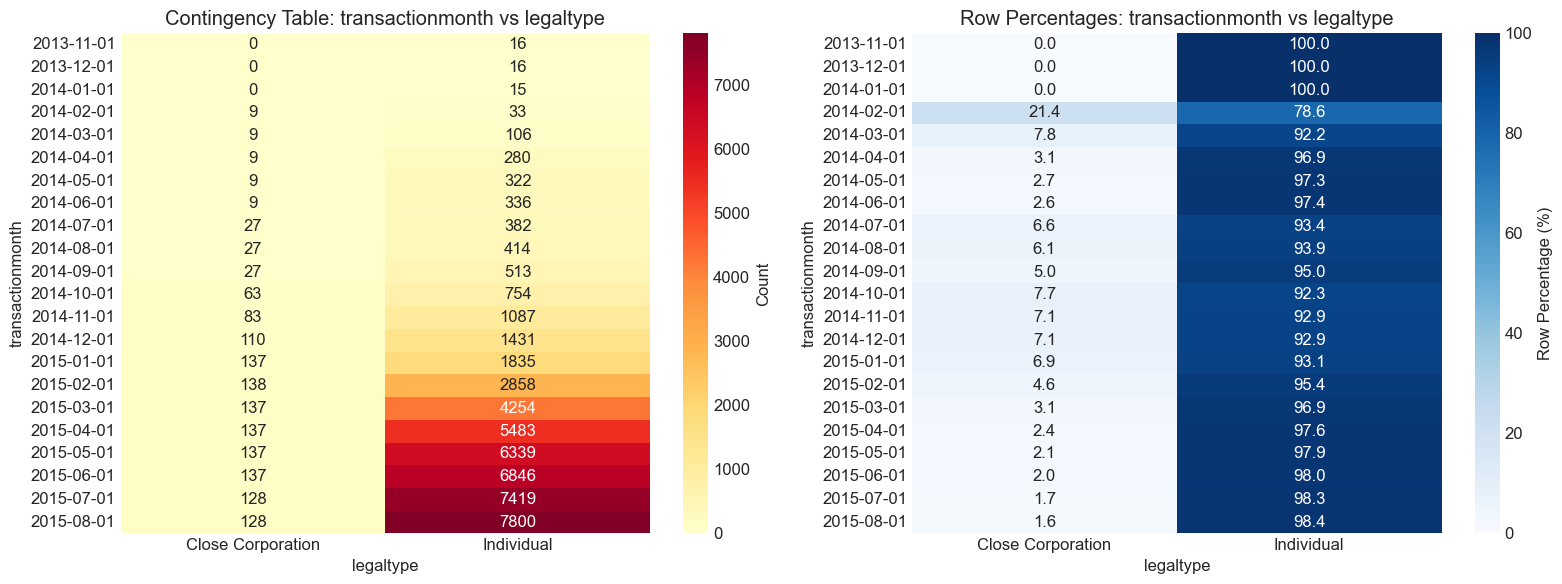

   ✅ Visualization saved: association_transactionmonth_vs_legaltype.png

✅ Results saved to reports folder:
   • Main results: categorical_association_results.csv
   • Contingency tables: 3 files
   • Visualizations: 1 files
   • Summary: categorical_association_summary.md

🔑 KEY INSIGHTS:
   • Significant associations: 1 out of 3 (33%)
   • Strongest association: transactionmonth vs legaltype (V = 0.111)


In [10]:
# Cell 8: Execute Categorical Analysis (WITH PROPER SAVING)
print("="*80)
print("🏷️ EXECUTING CATEGORICAL ASSOCIATION ANALYSIS")
print("="*80)

# Import necessary libraries
from scipy.stats import chi2_contingency
import itertools

# Define the analysis function if not already defined
def analyze_categorical_association(data, var1, var2):
    """Analyze association between two categorical variables"""
    # Create contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])
    
    # Check if table is valid
    if contingency_table.size == 0:
        return None
    
    # Calculate chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    return {
        'contingency_table': contingency_table,
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'cramers_v': cramers_v,
        'n': n
    }

# Select categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if len(categorical_cols) >= 2:
    print(f"\n🔍 Available categorical variables: {len(categorical_cols)}")
    for i, col in enumerate(categorical_cols[:10], 1):
        unique_count = df[col].nunique()
        missing_count = df[col].isnull().sum()
        print(f"   {i:2d}. {col:20} (Unique: {unique_count:3d}, Missing: {missing_count:3d})")
    
    # Select variables for analysis (choose based on your data)
    potential_cat_vars = ['Province', 'VehicleType', 'Gender', 'PaymentMethod', 'CoverType']
    available_cat_vars = [var for var in potential_cat_vars if var in df.columns]
    
    # If predefined vars not found, use the first few categorical columns
    if len(available_cat_vars) < 2:
        available_cat_vars = categorical_cols[:3]
        print(f"\n⚠️ Using first 3 categorical variables: {available_cat_vars}")
    
    if len(available_cat_vars) >= 2:
        # Create combinations
        combinations = list(itertools.combinations(available_cat_vars[:3], 2))
        
        print(f"\n📊 Analyzing {len(combinations)} categorical pairs:")
        
        association_results = []
        all_contingency_tables = {}
        
        for i, (var1, var2) in enumerate(combinations, 1):
            print(f"\n{i}. {var1} vs {var2}")
            try:
                result = analyze_categorical_association(df, var1, var2)
                if result:
                    # Store contingency table
                    all_contingency_tables[f"{var1}_vs_{var2}"] = result['contingency_table']
                    
                    # Interpret results
                    significance = "Significant" if result['p_value'] < 0.05 else "Not Significant"
                    strength = ""
                    if result['cramers_v'] < 0.1:
                        strength = "Very Weak"
                    elif result['cramers_v'] < 0.3:
                        strength = "Weak"
                    elif result['cramers_v'] < 0.5:
                        strength = "Moderate"
                    else:
                        strength = "Strong"
                    
                    print(f"   📊 Chi-square: {result['chi2']:.2f}")
                    print(f"   📊 P-value: {result['p_value']:.4f} ({significance})")
                    print(f"   📊 Cramer's V: {result['cramers_v']:.3f} ({strength} association)")
                    print(f"   📊 Sample size: {result['n']}")
                    
                    # FIXED: Create a variable for Cramer's V to avoid backslash in key
                    cramers_v_value = result['cramers_v']
                    
                    association_results.append({
                        'Variable 1': var1,
                        'Variable 2': var2,
                        'Chi-square': result['chi2'],
                        'P-value': result['p_value'],
                        'Cramer_V': cramers_v_value,  # FIXED: Changed key name
                        'Strength': strength,
                        'Significant': significance,
                        'Sample Size': result['n']
                    })
            except Exception as e:
                print(f"   ⚠️  Error: {e}")
        
        # Display summary
        if association_results:
            print("\n" + "="*80)
            print("📋 ASSOCIATION SUMMARY")
            print("="*80)
            
            assoc_df = pd.DataFrame(association_results)
            display(assoc_df)
            
            # FIXED: Save results to reports folder
            reports_dir = Path("../../reports")
            reports_dir.mkdir(parents=True, exist_ok=True)
            
            # Save main results
            assoc_path = reports_dir / "categorical_association_results.csv"
            assoc_df.to_csv(assoc_path, index=False, float_format='%.4f')
            
            # Save contingency tables
            for table_name, table_df in all_contingency_tables.items():
                table_path = reports_dir / f"contingency_table_{table_name}.csv"
                table_df.to_csv(table_path)
            
            # Create visualizations for significant associations
            print(f"\n📊 Creating visualizations for significant associations...")
            
            significant_pairs = assoc_df[assoc_df['Significant'] == 'Significant']
            
            if len(significant_pairs) > 0:
                for _, row in significant_pairs.iterrows():
                    try:
                        # Create heatmap of contingency table
                        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                        
                        # Get the contingency table
                        table_key = f"{row['Variable 1']}_vs_{row['Variable 2']}"
                        if table_key in all_contingency_tables:
                            contingency_table = all_contingency_tables[table_key]
                            
                            # Heatmap
                            sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd',
                                       ax=axes[0], cbar_kws={'label': 'Count'})
                            axes[0].set_title(f'Contingency Table: {row["Variable 1"]} vs {row["Variable 2"]}')
                            axes[0].set_xlabel(row['Variable 2'])
                            axes[0].set_ylabel(row['Variable 1'])
                            
                            # Normalized heatmap (row percentages)
                            row_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
                            sns.heatmap(row_pct, annot=True, fmt='.1f', cmap='Blues',
                                       ax=axes[1], cbar_kws={'label': 'Row Percentage (%)'})
                            axes[1].set_title(f'Row Percentages: {row["Variable 1"]} vs {row["Variable 2"]}')
                            axes[1].set_xlabel(row['Variable 2'])
                            axes[1].set_ylabel(row['Variable 1'])
                            
                            plt.tight_layout()
                            
                            # Save the visualization
                            viz_path = reports_dir / f"association_{row['Variable 1']}_vs_{row['Variable 2']}.png"
                            plt.savefig(viz_path, dpi=150, bbox_inches='tight')
                            plt.show()
                            
                            print(f"   ✅ Visualization saved: {viz_path.name}")
                    except Exception as e:
                        print(f"   ⚠️ Could not create visualization for {row['Variable 1']} vs {row['Variable 2']}: {e}")
            
            # Create summary markdown file with UTF-8 encoding
            md_path = reports_dir / "categorical_association_summary.md"
            with open(md_path, 'w', encoding='utf-8') as f:  # FIXED: Added UTF-8 encoding
                f.write("# Categorical Association Analysis Summary\n\n")
                f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
                f.write(f"**Dataset:** {df.shape[0]} rows × {df.shape[1]} columns\n\n")
                f.write(f"**Categorical Variables Analyzed:** {len(categorical_cols)}\n\n")
                
                f.write("## Association Test Results\n\n")
                f.write("Chi-square test results for categorical variable pairs:\n\n")
                
                # Create markdown table
                f.write("| Variable 1 | Variable 2 | Chi-square | P-value | Cramer's V | Strength | Significant |\n")
                f.write("|------------|------------|------------|---------|------------|----------|-------------|\n")
                
                for _, row in assoc_df.iterrows():
                    # FIXED: Use row['Cramer_V'] instead of row['Cramer\'s V']
                    f.write(f"| {row['Variable 1']} | {row['Variable 2']} | {row['Chi-square']:.2f} | {row['P-value']:.4f} | {row['Cramer_V']:.3f} | {row['Strength']} | {row['Significant']} |\n")
                
                f.write("\n## Interpretation Guide\n\n")
                f.write("### Cramer's V Strength:\n")
                f.write("- **< 0.1:** Very weak association\n")
                f.write("- **0.1 - 0.3:** Weak association\n")
                f.write("- **0.3 - 0.5:** Moderate association\n")
                f.write("- **> 0.5:** Strong association\n\n")
                
                f.write("### Statistical Significance:\n")
                f.write("- **P-value < 0.05:** Statistically significant association\n")
                f.write("- **P-value ≥ 0.05:** No statistically significant association\n\n")
                
                # Add business insights
                if not significant_pairs.empty:
                    f.write("## Business Insights\n\n")
                    
                    strongest_assoc = assoc_df.nlargest(1, "Cramer_V")
                    if not strongest_assoc.empty:
                        row = strongest_assoc.iloc[0]
                        # FIXED: Use 'vs' instead of '↔'
                        f.write(f"### Strongest Association: {row['Variable 1']} vs {row['Variable 2']}\n")
                        f.write(f"- **Cramer's V:** {row['Cramer_V']:.3f} ({row['Strength']} association)\n")
                        f.write(f"- **Statistical significance:** {row['Significant']} (p = {row['P-value']:.4f})\n")
                        f.write(f"- **Business implication:** These variables show the strongest relationship among all tested pairs\n\n")
                
                f.write("## Recommendations\n\n")
                if not significant_pairs.empty:
                    f.write("1. **Investigate significant associations** for potential business insights\n")
                    f.write("2. **Consider cross-tabulations** in your reporting for these variable pairs\n")
                    f.write("3. **Validate findings** with domain experts\n")
                else:
                    f.write("1. **No strong associations found** between the tested categorical variables\n")
                    f.write("2. **Consider testing different variable pairs** or including more variables\n")
                    f.write("3. **Focus on numerical correlations** which showed stronger relationships\n")
            
            print(f"\n✅ Results saved to reports folder:")
            print(f"   • Main results: {assoc_path.name}")
            print(f"   • Contingency tables: {len(all_contingency_tables)} files")
            print(f"   • Visualizations: {len(significant_pairs)} files")
            print(f"   • Summary: {md_path.name}")
            
            # Display insights
            print(f"\n🔑 KEY INSIGHTS:")
            
            # Count significant associations
            sig_count = len(significant_pairs)
            print(f"   • Significant associations: {sig_count} out of {len(assoc_df)} ({sig_count/len(assoc_df)*100:.0f}%)")
            
            # Find strongest association
            if not assoc_df.empty:
                strongest = assoc_df.nlargest(1, "Cramer_V").iloc[0]
                # FIXED: Use 'vs' instead of '↔'
                print(f"   • Strongest association: {strongest['Variable 1']} vs {strongest['Variable 2']} (V = {strongest['Cramer_V']:.3f})")
            
    else:
        print("⚠️ Not enough categorical variables for analysis")
else:
    print("⚠️ Not enough categorical variables in dataset")
    print(f"   Found only {len(categorical_cols)} categorical columns")
    
    # Check if there are low-cardinality numerical columns that could be treated as categorical
    potential_categorical = []
    for col in df.columns:
        if col not in categorical_cols and df[col].nunique() <= 10:
            potential_categorical.append(col)
    
    if potential_categorical:
        print(f"   Consider treating these as categorical (≤10 unique values):")
        for col in potential_categorical[:5]:
            print(f"     • {col}: {df[col].nunique()} unique values")

In [11]:
# Cell 9: Numerical vs Categorical Analysis - CORRECTED VERSION
print("="*80)
print("📊 NUMERICAL VS CATEGORICAL ANALYSIS")
print("="*80)

# Import necessary libraries
from scipy.stats import f_oneway

def analyze_numerical_categorical(df, num_var, cat_var):
    """
    Analyze relationship between numerical and categorical variables
    """
    print(f"\n📊 ANALYSIS: {num_var} by {cat_var}")
    print("-"*50)
    
    # Clean data
    data = df[[num_var, cat_var]].dropna()
    
    if len(data) < 10 or data[cat_var].nunique() < 2:
        print("⚠️ Insufficient data for analysis")
        return None
    
    # Calculate group statistics
    groups = data.groupby(cat_var)[num_var]
    group_stats = groups.agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{num_var} Distribution by {cat_var}', fontsize=16, fontweight='bold')
    
    # 1. Box Plot
    sns.boxplot(data=data, x=cat_var, y=num_var, ax=axes[0, 0], palette='Set2')
    axes[0, 0].set_title('Box Plot')
    axes[0, 0].set_xlabel(cat_var)
    axes[0, 0].set_ylabel(num_var)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Violin Plot
    sns.violinplot(data=data, x=cat_var, y=num_var, ax=axes[0, 1], palette='Set3')
    axes[0, 1].set_title('Violin Plot')
    axes[0, 1].set_xlabel(cat_var)
    axes[0, 1].set_ylabel(num_var)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Strip Plot (for smaller datasets)
    if len(data) < 1000:
        sns.stripplot(data=data, x=cat_var, y=num_var, ax=axes[0, 2], 
                     palette='Set1', alpha=0.5, jitter=True)
    else:
        sns.boxenplot(data=data, x=cat_var, y=num_var, ax=axes[0, 2], palette='Set1')
    axes[0, 2].set_title('Distribution Plot')
    axes[0, 2].set_xlabel(cat_var)
    axes[0, 2].set_ylabel(num_var)
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Bar Plot of Means
    group_means = groups.mean()
    axes[1, 0].bar(range(len(group_means)), group_means.values, 
                   color=plt.cm.Set3(np.arange(len(group_means))))
    axes[1, 0].set_title(f'Mean {num_var} by {cat_var}')
    axes[1, 0].set_xlabel(cat_var)
    axes[1, 0].set_ylabel(f'Mean {num_var}')
    axes[1, 0].set_xticks(range(len(group_means)))
    axes[1, 0].set_xticklabels(group_means.index, rotation=45)
    
    # 5. KDE Plot by Category
    for i, (category, group_data) in enumerate(groups):
        sns.kdeplot(data=group_data, ax=axes[1, 1], label=category, 
                   fill=True, alpha=0.3)
    axes[1, 1].set_title('Density Distribution by Category')
    axes[1, 1].set_xlabel(num_var)
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend(title=cat_var)
    
    # 6. Statistics Summary
    axes[1, 2].axis('off')
    
    # Perform ANOVA if enough groups
    f_stat, p_value = None, None
    if data[cat_var].nunique() >= 2:
        anova_groups = [group for _, group in groups]
        if all(len(g) > 0 for g in anova_groups):  # Ensure all groups have data
            try:
                f_stat, p_value = f_oneway(*anova_groups)
            except Exception as e:
                print(f"   ⚠️ ANOVA failed: {e}")
                f_stat, p_value = None, None
    
    stats_text = f"📊 GROUP STATISTICS\n{'='*40}\n"
    stats_text += f"Total Observations: {len(data):,}\n"
    stats_text += f"Number of Groups: {data[cat_var].nunique()}\n\n"
    
    stats_text += f"📈 DESCRIPTIVE STATISTICS:\n"
    for idx, row in group_stats.iterrows():
        stats_text += f"  {idx}:\n"
        stats_text += f"    Count: {row['count']:,}\n"
        stats_text += f"    Mean: {row['mean']:.2f}\n"
        stats_text += f"    Std: {row['std']:.2f}\n"
        stats_text += f"    Median: {row['median']:.2f}\n"
    
    if f_stat is not None and p_value is not None:
        stats_text += f"\n📊 ANOVA TEST:\n"
        stats_text += f"  F-statistic: {f_stat:.2f}\n"
        stats_text += f"  P-value: {p_value:.6f}\n"
        stats_text += f"  {'Significant difference between groups (p < 0.05)' if p_value < 0.05 else 'No significant difference between groups'}\n"
    elif data[cat_var].nunique() >= 2:
        stats_text += f"\n📊 ANOVA TEST:\n"
        stats_text += f"  Could not perform ANOVA test\n"
    
    stats_text += f"\n💡 INSIGHTS:\n"
    if f_stat is not None and p_value is not None and p_value < 0.05:
        # Find groups with highest and lowest means
        max_group = group_stats['mean'].idxmax()
        min_group = group_stats['mean'].idxmin()
        max_mean = group_stats.loc[max_group, 'mean']
        min_mean = group_stats.loc[min_group, 'mean']
        
        stats_text += f"• {max_group} has highest mean ({max_mean:.2f})\n"
        stats_text += f"• {min_group} has lowest mean ({min_mean:.2f})\n"
        stats_text += f"• Difference: {max_mean - min_mean:.2f}\n"
    elif f_stat is not None and p_value is not None:
        stats_text += f"• Groups show similar average values\n"
    else:
        stats_text += f"• ANOVA test not performed or failed\n"
    
    axes[1, 2].text(0.1, 0.95, stats_text, fontfamily='monospace', fontsize=9,
                   verticalalignment='top', transform=axes[1, 2].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    
    # Save the visualization to reports directory
    reports_dir = Path("../../reports")
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    # Clean variable names for filename
    clean_num_var = num_var.replace(' ', '_').replace('/', '_')
    clean_cat_var = cat_var.replace(' ', '_').replace('/', '_')
    viz_filename = f"num_vs_cat_{clean_num_var}_by_{clean_cat_var}.png"
    viz_path = reports_dir / viz_filename
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    print(f"✅ Visualization saved: {viz_path.name}")
    
    # Close the plot to avoid display issues
    plt.close(fig)
    
    results = {
        'numerical_variable': num_var,
        'categorical_variable': cat_var,
        'group_stats': group_stats,
        'sample_size': len(data),
        'num_groups': data[cat_var].nunique()
    }
    
    if f_stat is not None and p_value is not None:
        results.update({
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        })
    
    return results

# Execute analysis for key variable pairs
print("\n🔍 Analyzing numerical vs categorical relationships...")

# Find ALL numerical columns
all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 Found {len(all_numeric_cols)} numerical columns total")

# Find categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"🏷️ Found {len(categorical_cols)} categorical columns total")

# First, let's identify meaningful numerical variables (not ID columns)
# Common insurance numerical variables that make sense to analyze
meaningful_numeric_vars = []
id_patterns = ['id', 'ID', 'Id', 'code', 'Code', 'num', 'Num', 'No', 'no']

for col in all_numeric_cols:
    col_lower = col.lower()
    is_id_column = any(pattern in col_lower for pattern in id_patterns)
    
    # Check if column has meaningful variation (not just sequential IDs)
    unique_ratio = df[col].nunique() / len(df)
    
    if not is_id_column and unique_ratio < 0.8:  # Not an ID column and not all unique values
        meaningful_numeric_vars.append(col)
    elif is_id_column:
        print(f"   ⚠️ Skipping likely ID column: {col}")

print(f"\n🔍 Selected meaningful numerical variables: {len(meaningful_numeric_vars)}")

# If we don't have enough meaningful numerical variables, use correlation to find interesting ones
if len(meaningful_numeric_vars) < 2:
    print("⚠️ Not enough meaningful numerical variables found automatically.")
    print("🔍 Looking for numerical variables with correlation to target...")
    
    # Try to find columns that look like amounts, premiums, claims, etc.
    amount_patterns = ['premium', 'Premium', 'claim', 'Claim', 'amount', 'Amount', 
                       'value', 'Value', 'sum', 'Sum', 'cost', 'Cost', 'price', 'Price',
                       'risk', 'Risk', 'score', 'Score', 'age', 'Age', 'year', 'Year',
                       'discount', 'Discount', 'rate', 'Rate']
    
    for col in all_numeric_cols:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in amount_patterns):
            meaningful_numeric_vars.append(col)
    
    # Remove duplicates
    meaningful_numeric_vars = list(set(meaningful_numeric_vars))
    print(f"   Found {len(meaningful_numeric_vars)} variables based on name patterns")

# If still not enough, take the first few non-ID columns
if len(meaningful_numeric_vars) < 2:
    print("⚠️ Still not enough variables. Using first available numerical columns...")
    for col in all_numeric_cols:
        if col not in meaningful_numeric_vars and len(meaningful_numeric_vars) < 5:
            meaningful_numeric_vars.append(col)

print(f"\n📋 Final numerical variables for analysis:")
for i, var in enumerate(meaningful_numeric_vars[:5], 1):
    print(f"   {i:2d}. {var} (unique: {df[var].nunique():,})")

# Handle categorical variables
if len(categorical_cols) == 0:
    print("\n⚠️ No categorical columns found. Looking for low-cardinality numerical columns...")
    for col in all_numeric_cols:
        if df[col].nunique() <= 10 and df[col].nunique() > 1 and col not in meaningful_numeric_vars:
            categorical_cols.append(col)
            print(f"   • Treating {col} as categorical ({df[col].nunique()} unique values)")

# Select analysis pairs
analysis_pairs = []
all_results = []

if len(meaningful_numeric_vars) >= 1 and len(categorical_cols) >= 1:
    # Use up to 3 numerical variables and up to 2 categorical variables
    selected_numeric = meaningful_numeric_vars[:min(3, len(meaningful_numeric_vars))]
    selected_categorical = categorical_cols[:min(2, len(categorical_cols))]
    
    # Create pairs
    for num_var in selected_numeric:
        for cat_var in selected_categorical:
            # Skip if both are likely the same type of variable
            if num_var != cat_var:
                analysis_pairs.append((num_var, cat_var))
    
    print(f"\n📋 Analysis Plan:")
    print(f"   • Numerical variables: {', '.join(selected_numeric)}")
    print(f"   • Categorical variables: {', '.join(selected_categorical)}")
    print(f"   • Total pairs to analyze: {len(analysis_pairs)}")
    
    # Execute analysis for each pair
    successful_analyses = 0
    for num_var, cat_var in analysis_pairs:
        print(f"\n{'='*60}")
        print(f"🔍 Processing: {num_var} by {cat_var}")
        print(f"{'='*60}")
        
        results = analyze_numerical_categorical(df, num_var, cat_var)
        if results:
            all_results.append(results)
            successful_analyses += 1
    
    # Create comprehensive summary
    if all_results:
        print("\n" + "="*80)
        print("📊 NUMERICAL VS CATEGORICAL ANALYSIS SUMMARY")
        print("="*80)
        print(f"✅ Successfully analyzed {successful_analyses}/{len(analysis_pairs)} pairs")
        
        # Extract summary statistics
        summary_data = []
        for result in all_results:
            summary_data.append({
                'Numerical_Variable': result['numerical_variable'],
                'Categorical_Variable': result['categorical_variable'],
                'Sample_Size': result['sample_size'],
                'Number_of_Groups': result['num_groups'],
                'F_Statistic': result.get('f_statistic', 'N/A'),
                'P_Value': result.get('p_value', 'N/A'),
                'Significant': 'Yes' if result.get('significant', False) else 'No',
                'Max_Group': result['group_stats']['mean'].idxmax() if 'group_stats' in result else 'N/A',
                'Min_Group': result['group_stats']['mean'].idxmin() if 'group_stats' in result else 'N/A'
            })
        
        summary_df = pd.DataFrame(summary_data)
        print(f"\n📋 Summary Table:")
        print(summary_df.to_string())
        
        # Save summary to reports directory
        reports_dir = Path("../../reports")
        summary_path = reports_dir / "numerical_vs_categorical_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\n✅ Summary saved to: {summary_path}")
        
        # Create detailed markdown report
        md_path = reports_dir / "numerical_vs_categorical_analysis.md"
        with open(md_path, 'w', encoding='utf-8') as f:
            f.write("# Numerical vs Categorical Analysis Report\n\n")
            f.write(f"**Analysis Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(f"**Dataset:** {df.shape[0]} rows × {df.shape[1]} columns\n\n")
            f.write(f"**Total Pairs Attempted:** {len(analysis_pairs)}\n")
            f.write(f"**Successfully Analyzed:** {successful_analyses}\n\n")
            
            f.write("## Key Findings\n\n")
            
            # Find significant results
            significant_results = [r for r in all_results if r.get('significant', False)]
            if significant_results:
                f.write(f"### Significant Differences Found: {len(significant_results)}/{len(all_results)} pairs\n\n")
                
                for result in significant_results:
                    f.write(f"#### {result['numerical_variable']} by {result['categorical_variable']}\n")
                    f.write(f"- **F-statistic:** {result['f_statistic']:.2f}\n")
                    f.write(f"- **P-value:** {result['p_value']:.6f}\n")
                    
                    # Get group statistics
                    group_stats = result['group_stats']
                    max_group = group_stats['mean'].idxmax()
                    min_group = group_stats['mean'].idxmin()
                    max_mean = group_stats.loc[max_group, 'mean']
                    min_mean = group_stats.loc[min_group, 'mean']
                    difference = max_mean - min_mean
                    
                    f.write(f"- **Highest mean:** {max_group} ({max_mean:.2f})\n")
                    f.write(f"- **Lowest mean:** {min_group} ({min_mean:.2f})\n")
                    f.write(f"- **Difference:** {difference:.2f}\n\n")
            else:
                f.write("### No Significant Differences Found\n\n")
                f.write("No statistically significant differences were found between groups for any of the analyzed pairs.\n\n")
            
            f.write("## Detailed Statistics\n\n")
            f.write("| Numerical Variable | Categorical Variable | Groups | Sample Size | F-statistic | P-value | Significant |\n")
            f.write("|--------------------|----------------------|--------|-------------|-------------|---------|-------------|\n")
            
            for _, row in summary_df.iterrows():
                f_val = f"{row['F_Statistic']:.2f}" if row['F_Statistic'] != 'N/A' and isinstance(row['F_Statistic'], (int, float)) else str(row['F_Statistic'])
                p_val = f"{row['P_Value']:.6f}" if row['P_Value'] != 'N/A' and isinstance(row['P_Value'], (int, float)) else str(row['P_Value'])
                f.write(f"| {row['Numerical_Variable']} | {row['Categorical_Variable']} | {row['Number_of_Groups']} | {row['Sample_Size']} | {f_val} | {p_val} | {row['Significant']} |\n")
            
            f.write("\n## Files Generated\n\n")
            f.write("1. **Summary CSV:** `numerical_vs_categorical_summary.csv`\n")
            f.write("2. **Visualizations:** PNG files for each variable pair\n")
            f.write("3. **This Report:** `numerical_vs_categorical_analysis.md`\n\n")
            
            f.write("## Recommendations\n\n")
            if significant_results:
                f.write("1. **Investigate significant differences** found in the analysis\n")
                f.write("2. **Consider stratifying analysis** by these categorical variables\n")
                f.write("3. **Validate findings** with business domain experts\n")
            else:
                f.write("1. **No segmentation needed** based on tested categorical variables\n")
                f.write("2. **Consider testing different categorical variables**\n")
                f.write("3. **Focus on other analysis methods** for insights\n")
        
        print(f"✅ Detailed report saved to: {md_path}")
        
        # Print key insights
        print(f"\n🔑 KEY INSIGHTS:")
        print(f"   • Total pairs analyzed: {len(all_results)}")
        
        significant_count = len([r for r in all_results if r.get('significant', False)])
        print(f"   • Significant differences found: {significant_count} ({significant_count/len(all_results)*100:.0f}% of successful analyses)")
        
        if significant_count > 0:
            sig_vars = summary_df[summary_df['Significant'] == 'Yes']['Numerical_Variable'].unique()[:3]
            print(f"   • Variables with most significant differences: {', '.join(sig_vars)}")
            
        print(f"\n📁 All outputs saved to: {reports_dir}")
        print(f"   • Summary CSV: {summary_path.name}")
        print(f"   • Detailed report: {md_path.name}")
        print(f"   • Visualizations: {successful_analyses} PNG files")
        
else:
    print("⚠️ Insufficient variables for numerical vs categorical analysis")
    print(f"   Meaningful numerical variables: {len(meaningful_numeric_vars)}")
    print(f"   Categorical variables: {len(categorical_cols)}")
    print("\n💡 SUGGESTIONS:")
    print("   1. Check if your dataset has proper numerical variables (amounts, counts, measurements)")
    print("   2. Ensure categorical variables have been properly identified")
    print("   3. Consider converting some numerical columns to categorical if they have few unique values")

📊 NUMERICAL VS CATEGORICAL ANALYSIS

🔍 Analyzing numerical vs categorical relationships...
📊 Found 15 numerical columns total
🏷️ Found 36 categorical columns total
   ⚠️ Skipping likely ID column: underwrittencoverid
   ⚠️ Skipping likely ID column: policyid
   ⚠️ Skipping likely ID column: postalcode
   ⚠️ Skipping likely ID column: mmcode
   ⚠️ Skipping likely ID column: numberofdoors
   ⚠️ Skipping likely ID column: numberofvehiclesinfleet

🔍 Selected meaningful numerical variables: 9

📋 Final numerical variables for analysis:
    1. cylinders (unique: 6)
    2. cubiccapacity (unique: 57)
    3. kilowatts (unique: 48)
    4. customvalueestimate (unique: 200)
    5. capitaloutstanding (unique: 234)

📋 Analysis Plan:
   • Numerical variables: cylinders, cubiccapacity, kilowatts
   • Categorical variables: transactionmonth, citizenship
   • Total pairs to analyze: 6

🔍 Processing: cylinders by transactionmonth

📊 ANALYSIS: cylinders by transactionmonth
---------------------------------